In [1]:
# セル1 --- imports / seed / paths ---
import os
import math
import random
import copy
import shutil
from pathlib import Path
from typing import Dict, List, Tuple
from math import inf

import numpy as np
import pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.cuda.amp import autocast

try:
    import timm
except ImportError as e:
    raise ImportError("timm が見つかりません。`pip install -U timm` でインストールしてください。") from e


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ===== パス（ここが変更点）=====
BASE_DIR = Path("/home/yyamashita/Desktop/yyama/LDL_SwinT-S")
CSV_PATH = BASE_DIR / "対照表_１回検査.csv"

RUNS_DIR = BASE_DIR / "Runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# 例：モデル保存用ディレクトリ（好みで変更OK）
SAVE_DIR = RUNS_DIR / "学習後モデル"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

best_infer_path = SAVE_DIR / "best_model_infer.pt"
best_train_path = SAVE_DIR / "best_model_train.pt"
curve_png_path  = SAVE_DIR / "learning_curves.png"

print("BASE_DIR:", BASE_DIR)
print("CSV_PATH:", CSV_PATH)
print("RUNS_DIR:", RUNS_DIR)
print("SAVE_DIR:", SAVE_DIR)

BASE_DIR: /home/user/デスクトップ/age_estimation_12.12
CSV_PATH: /home/user/デスクトップ/age_estimation_12.12/対照表_１回検査.csv
RUNS_DIR: /home/user/デスクトップ/age_estimation_12.12/Runs
SAVE_DIR: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3


/home/user/anaconda3/envs/dl-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# セル2 --- CSV load & normalize ---
def load_and_normalize_csv(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # 列名の統一（Age）
    if "Age" not in df.columns and "PatientAge" in df.columns:
        df = df.rename(columns={"PatientAge": "Age"})

    # 必須列
    required = {"ResearchID", "split", "Age"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"CSVに必須列が不足しています: {missing}")

    # 型・表記の正規化
    df["ResearchID"] = df["ResearchID"].astype(str).str.strip()
    df["split"]      = df["split"].astype(str).str.lower().str.strip()
    df["Age"]        = pd.to_numeric(df["Age"], errors="coerce")

    # 使用するsplitは train / val のみ
    df = df[df["split"].isin(["train", "val"])].copy()

    # 欠損Age除外
    df = df.dropna(subset=["Age"]).reset_index(drop=True)

    AGE_MIN, AGE_MAX = 40, 80  # 例：40〜80を使う
    df = df[(df["Age"] >= AGE_MIN) & (df["Age"] <= AGE_MAX)].copy()
    df = df.reset_index(drop=True)

    return df

meta_df = load_and_normalize_csv(CSV_PATH)
print("Loaded rows:", len(meta_df))
print(meta_df.head())
print("\nCounts by split:\n", meta_df.groupby(["split"]).size())

Loaded rows: 4721
                                          ResearchID  Age  StudyDate 診断名称  \
0  97f767155d6225462a3848c3cf845a0c0d025db18fbe6b...   70   20150119  NaN   
1  284a3c45e9cad43656370c8d418121f02b7a92749d021b...   66   20150106  NaN   
2  c000868e6a06bc9eed12c4e9b63da9254c0b314e6b7c31...   67   20150114  NaN   
3  8ca282e462a3cbd93549b564a6cf1e06bf25897e5ffc62...   42   20150116  NaN   
4  a676bce0ebcd30d9a7a61ca2c442917fcc854065422ae4...   66   20150105  NaN   

   split  
0  train  
1  train  
2  train  
3    val  
4  train  

Counts by split:
 split
train    3776
val       945
dtype: int64


In [3]:
# セル3 --- patient splits & age map ---
def build_patient_splits(df: pd.DataFrame) -> Dict[str, List[str]]:
    splits = {}
    for sp in ["train", "val"]:
        pids = df.loc[df["split"] == sp, "ResearchID"].astype(str).unique().tolist()
        splits[sp] = sorted(pids)
    return splits

patient_splits = build_patient_splits(meta_df)

# 同一ResearchIDで複数行ある場合は平均年齢で集約
age_map = meta_df.groupby("ResearchID")["Age"].mean().astype(float).to_dict()

print("#patients  train:", len(patient_splits["train"]), " / val:", len(patient_splits["val"]))
print("Sample age_map:", list(age_map.items())[:5])

#patients  train: 3776  / val: 945
Sample age_map: [('0018798c5def11c7df8a0ac13c31912dd8be0a5536cc6ec777cf944c55c5a191', 71.0), ('001b7b0d5556c5192c39159b9e417cd57dcea2576e152743583329af579ce5a6', 77.0), ('0022b0c38f1342dbc92fe850f0c90214f1541bdcf4bf5aa289f6968b66c342e4', 61.0), ('0024a728aa35d9e1c879caa199091d257cbfaada1052965343e74276cc246192', 60.0), ('004ea38cd0c708dfe38c60829066f25d2fdb3f31bc002ed71a91b4bcd93c1038', 67.0)]


In [4]:
# セル4 --- index images by ResearchID only ---
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm
import pandas as pd

IMAGE_ROOT = Path("/home/yyamashita/Desktop/yyama/ES_PNG_ROI_processed")  

def index_patient_images(
    df: pd.DataFrame,
    image_root: Path,
    exts: Tuple[str, ...] = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"),
) -> Dict[str, List[Path]]:
    """
    {image_root}/{ResearchID}/ 以下を再帰的に探索して
    患者ID -> 画像パス一覧 を作る。
    ExamNumber は一切使わない。
    """

    if "ResearchID" not in df.columns:
        raise KeyError("CSVに必須列 'ResearchID' がありません。")

    patient2paths: Dict[str, List[Path]] = {}

    patient_ids = df["ResearchID"].astype(str).str.strip().unique().tolist()

    for rid in tqdm(patient_ids, desc="Indexing images by ResearchID"):
        rid = str(rid).strip()
        rid_dir = image_root / rid
        if not rid_dir.exists():
            continue

        # ResearchID配下を再帰的に探索
        imgs = [
            p for p in rid_dir.rglob("*")
            if p.is_file() and p.suffix.lower() in exts
        ]
        if not imgs:
            continue

        patient2paths[rid] = sorted(set(imgs))

    return patient2paths


# 実行
patient2paths = index_patient_images(meta_df, IMAGE_ROOT)
print("Indexed patients with images:", len(patient2paths))

Indexing images by ResearchID: 100%|██████████| 4721/4721 [00:01<00:00, 2409.63it/s]

Indexed patients with images: 4694


In [5]:
# セル5 --- filter patients with images ---
def filter_patients_with_images(patient_ids: List[str], p2p: Dict[str, List[Path]]) -> List[str]:
    return [pid for pid in patient_ids if pid in p2p and len(p2p[pid]) > 0]

train_patients = filter_patients_with_images(patient_splits["train"], patient2paths)
val_patients   = filter_patients_with_images(patient_splits["val"],   patient2paths)

print("#usable patients  train:", len(train_patients), " / val:", len(val_patients))

#usable patients  train: 3758  / val: 936


In [6]:
# セル6 --- transforms ---
IMG_SIZE = 224
MAX_FRAMES_PER_PATIENT = 80

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# キャッシュ後に適用する変換（学習時）
train_tfms_runtime = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.67, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# 検証時（Normalizeのみ）
val_tfms_runtime = transforms.Compose([
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

def pil_loader(path: Path):
    with Image.open(path) as img:
        return img.convert("RGB")

In [7]:
# セル7 --- cache config (level1: resize->tensor) ---
import hashlib
import json

BASE_TFMS = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # [0,1] float32 CHW
])

# ===== 変更点：キャッシュも Runs 配下へ =====
CACHE_ROOT = RUNS_DIR / "cache_lvl1_resized_tensors"
CACHE_ROOT.mkdir(parents=True, exist_ok=True)

CACHE_VERSION = {
    "img_size": IMG_SIZE,
    "pipeline": "resize->tensor",
    "mean": list(map(float, IMAGENET_MEAN)),
    "std":  list(map(float, IMAGENET_STD)),
}
CACHE_TAG = hashlib.md5(json.dumps(CACHE_VERSION, sort_keys=True).encode()).hexdigest()[:8]

def _cache_path_for_image(path: Path) -> Path:
    """
    {CACHE_ROOT}/{CACHE_TAG}/{rid}/{sha1(abs_path)}.pt
    rid は IMAGE_ROOT/{rid}/... を仮定して推定
    """
    parts = [p for p in path.parts if p]
    rid = "unknown"
    try:
        idx = parts.index(IMAGE_ROOT.name)
        rid = parts[idx + 1]
    except Exception:
        pass

    h = hashlib.sha1(str(path.resolve()).encode()).hexdigest()
    return CACHE_ROOT / CACHE_TAG / rid / f"{h}.pt"

In [8]:
# セル8 --- validate images in parallel ---
from concurrent.futures import ThreadPoolExecutor
from PIL import UnidentifiedImageError

# 全画像パス収集
all_paths = []
for rid, paths in patient2paths.items():
    all_paths.extend(paths)
all_paths = [Path(p) for p in dict.fromkeys(all_paths)]  # 重複除去（順序保持）
print(f"🔍 検証対象の総画像枚数: {len(all_paths)} 枚")

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def quick_reject(p: Path) -> bool:
    if p.suffix.lower() not in VALID_EXT:
        return True
    try:
        if p.stat().st_size == 0:
            return True
    except FileNotFoundError:
        return True
    return False

def is_valid_image(path: Path) -> bool:
    if quick_reject(path):
        return False
    try:
        with Image.open(path) as im:
            im.load()  # 実デコード
        return True
    except (UnidentifiedImageError, OSError, ValueError):
        return False

def validate_images_parallel(paths, max_workers: int | None = None):
    if max_workers is None:
        max_workers = min(64, (os.cpu_count() or 8) * 2)

    invalid = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for p, ok in tqdm(
            zip(paths, ex.map(is_valid_image, paths)),
            total=len(paths),
            desc="Validating images",
            leave=False
        ):
            if not ok:
                invalid.append(p)
    return invalid

invalid_paths = validate_images_parallel(all_paths)

invalid_set = set(invalid_paths)
filtered_patient2paths = {}
for rid, paths in patient2paths.items():
    kept = [p for p in paths if Path(p) not in invalid_set]
    if kept:
        filtered_patient2paths[rid] = kept

removed_patients = set(patient2paths.keys()) - set(filtered_patient2paths.keys())
print(f"✅ Validated patients with images: {len(filtered_patient2paths)} (removed patients: {len(removed_patients)})")
print(f"🚫 Removed invalid images: {len(invalid_paths)} / {len(all_paths)}")

patient2paths = filtered_patient2paths

# 画像あり患者のみ再構成
train_patients = filter_patients_with_images(patient_splits["train"], patient2paths)
val_patients   = filter_patients_with_images(patient_splits["val"],   patient2paths)
print(f"#usable patients  train: {len(train_patients)} / val: {len(val_patients)}")

🔍 検証対象の総画像枚数: 131084 枚


✅ Validated patients with images: 4694 (removed patients: 0)
🚫 Removed invalid images: 0 / 131084
#usable patients  train: 3758 / val: 936


In [9]:
# セル9 --- build cache if needed ---
def build_level1_cache(
    patient2paths: Dict[str, List[Path]],
    base_tfms=BASE_TFMS,
    overwrite: bool = False
) -> Tuple[int, int]:
    written, skipped = 0, 0

    all_paths = []
    for rid, paths in patient2paths.items():
        all_paths.extend(paths)
    all_paths = list(dict.fromkeys(all_paths))

    for p in tqdm(all_paths, desc=f"Building cache (tag={CACHE_TAG})"):
        out = _cache_path_for_image(p)
        if out.exists() and not overwrite:
            skipped += 1
            continue
        out.parent.mkdir(parents=True, exist_ok=True)
        try:
            img = pil_loader(p)
            ten = base_tfms(img)      # Resize→ToTensor
            torch.save(ten, out)
            written += 1
        except Exception:
            continue

    return written, skipped

def estimate_cache_hit_ratio(
    patient2paths: Dict[str, List[Path]],
    sample_limit_per_patient: int = 12
) -> float:
    total, hits = 0, 0
    for rid, paths in patient2paths.items():
        check_paths = paths[:sample_limit_per_patient] if sample_limit_per_patient else paths
        for p in check_paths:
            total += 1
            if _cache_path_for_image(p).exists():
                hits += 1
    return (hits / total) if total > 0 else 1.0

HIT_THRESHOLD = 0.90
hit_ratio = estimate_cache_hit_ratio(patient2paths, sample_limit_per_patient=12)
print(f"🧮 Cache hit ratio (rough): {hit_ratio:.1%} (threshold={HIT_THRESHOLD:.0%})")

if hit_ratio < HIT_THRESHOLD:
    print("⚙️ キャッシュが十分でないため、前計算を実行します…")
    w, s = build_level1_cache(patient2paths, overwrite=False)
    print(f"Cache built. written={w}, skipped={s}")
else:
    print("✅ キャッシュは十分と判断。前計算はスキップします。")

print("🧭 キャッシュサンプル確認:")
some = list(CACHE_ROOT.glob("**/*.pt"))[:5]
print(f"  例: {len(some)}件中5件を表示")
for p in some:
    print(" ", p)

🧮 Cache hit ratio (rough): 100.0% (threshold=90%)
✅ キャッシュは十分と判断。前計算はスキップします。
🧭 キャッシュサンプル確認:
  例: 5件中5件を表示
  /home/user/デスクトップ/age_estimation_12.12/Runs/cache_lvl1_resized_tensors/80f5bc8a/4999cdf1d2c1456d731a5c6ca1aef94d6aa495493c7d4144223ca1f7167de478/310c2544530700176d06f8a9f6c8828d98e366b7.pt
  /home/user/デスクトップ/age_estimation_12.12/Runs/cache_lvl1_resized_tensors/80f5bc8a/4999cdf1d2c1456d731a5c6ca1aef94d6aa495493c7d4144223ca1f7167de478/b844f8c7a7afccb20fd57ead290e72719540ee62.pt
  /home/user/デスクトップ/age_estimation_12.12/Runs/cache_lvl1_resized_tensors/80f5bc8a/4999cdf1d2c1456d731a5c6ca1aef94d6aa495493c7d4144223ca1f7167de478/61abe73976e5b37bbff92be813962cf621f73222.pt
  /home/user/デスクトップ/age_estimation_12.12/Runs/cache_lvl1_resized_tensors/80f5bc8a/4999cdf1d2c1456d731a5c6ca1aef94d6aa495493c7d4144223ca1f7167de478/6969d784e75c452c7395f6378a05c863bc31786a.pt
  /home/user/デスクトップ/age_estimation_12.12/Runs/cache_lvl1_resized_tensors/80f5bc8a/4999cdf1d2c1456d731a5c6ca1aef94d6aa495493c7d4144

In [10]:
# セル10 --- Dataset (patient as a bag) ---
ImageFile.LOAD_TRUNCATED_IMAGES = True

def is_readable_image(path: Path) -> bool:
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception:
        return False

class PatientFramesDataset(Dataset):
    """
    1サンプル=1患者（バッグ）
      return:
        images: Tensor [Mi, C, H, W]
        age   : Tensor []
        pid   : str
    - train: ランダムサブサンプル
    - val  : 等間隔サブサンプル
    - use_cache=True: Resize→ToTensor を .pt からロード、runtime_tfmsを適用
    """
    def __init__(
        self,
        patient_ids: List[str],
        patient2paths: Dict[str, List[Path]],
        age_map: Dict[str, float],
        split: str = "train",
        runtime_tfms=None,
        max_frames: int = 80,
        use_cache: bool = True,
    ):
        self.pids = patient_ids
        self.patient2paths = patient2paths
        self.age_map = age_map
        self.split = split
        self.runtime_tfms = runtime_tfms
        self.max_frames = max_frames
        self.use_cache = use_cache

    def __len__(self):
        return len(self.pids)

    def _choose_indices(self, n: int) -> np.ndarray:
        m = min(n, self.max_frames)
        if self.split == "train":
            if n <= m:
                return np.arange(n, dtype=int)
            idx = np.random.permutation(n)[:m]
            return np.sort(idx)
        else:
            if n <= m:
                return np.arange(n, dtype=int)
            xs = np.linspace(0, n - 1, num=m)
            idx = np.unique(np.round(xs).astype(int))
            if len(idx) > m:
                idx = idx[:m]
            elif len(idx) < m:
                pad = np.full(m - len(idx), idx[-1], dtype=int)
                idx = np.concatenate([idx, pad])
            return idx

    def _load_from_cache(self, path: Path) -> torch.Tensor:
        cpath = _cache_path_for_image(path)
        if not cpath.exists():
            img = pil_loader(path)
            ten = BASE_TFMS(img)  # Resize→ToTensor
            cpath.parent.mkdir(parents=True, exist_ok=True)
            torch.save(ten, cpath)
            return ten
        return torch.load(cpath, map_location="cpu")  # CHW float32 [0..1]

    def __getitem__(self, i: int):
        pid = self.pids[i]
        paths = self.patient2paths[pid]
        age = float(self.age_map[pid])

        readable_paths = [p for p in paths if is_readable_image(p)]
        if len(readable_paths) == 0:
            return None

        sel = self._choose_indices(len(readable_paths))
        chosen_paths = [readable_paths[j] for j in sel]

        imgs = []
        for p in chosen_paths:
            try:
                if self.use_cache:
                    img_t = self._load_from_cache(p)
                else:
                    img = pil_loader(p)
                    img_t = BASE_TFMS(img)

                if self.runtime_tfms is not None:
                    img_t = self.runtime_tfms(img_t)
                imgs.append(img_t)
            except Exception:
                continue

        if len(imgs) == 0:
            for p in paths:
                try:
                    if self.use_cache:
                        img_t = self._load_from_cache(p)
                    else:
                        img = pil_loader(p)
                        img_t = BASE_TFMS(img)
                    if self.runtime_tfms is not None:
                        img_t = self.runtime_tfms(img_t)
                    imgs.append(img_t)
                    break
                except Exception:
                    continue

        if len(imgs) == 0:
            return None

        images = torch.stack(imgs, dim=0)  # [Mi, C, H, W]
        return images, torch.tensor(age, dtype=torch.float32), pid

In [11]:
# セル11 --- collate + patient_slices検証 ---
import torch
import numpy as np
from typing import List

DEBUG_CHECK_SLICES = False      # ←普段は False、疑うときだけ True
DEBUG_CHECK_PROB   = 0.02       # ←全バッチのうち何割チェックするか（例:2%）
DEBUG_STRICT_EQUAL = True       # ←True: テンソル一致まで検証（重い）

def collate_patient_frames(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None

    images_list, ages_list, pids = zip(*batch)
    lengths = [x.shape[0] for x in images_list]

    starts = np.cumsum([0] + lengths[:-1]).tolist()
    ends   = np.cumsum(lengths).tolist()
    patient_slices = list(zip(starts, ends))

    images_cat = torch.cat(images_list, dim=0)     # [T,C,H,W]
    ages = torch.stack(list(ages_list), dim=0)     # [B]

    # ===== 検証（必要なときだけ）=====
    if DEBUG_CHECK_SLICES and (np.random.rand() < DEBUG_CHECK_PROB):
        # 1) 基本整合性
        assert patient_slices[0][0] == 0
        assert patient_slices[-1][1] == images_cat.shape[0]
        for i, (s, e) in enumerate(patient_slices):
            assert 0 <= s < e <= images_cat.shape[0]
            if i > 0:
                s_prev, e_prev = patient_slices[i-1]
                assert s == e_prev, f"non-contiguous slices: prev={patient_slices[i-1]} now={patient_slices[i]}"
            assert (e - s) == lengths[i], f"length mismatch: slice={e-s}, orig={lengths[i]}"

        # 2) （重いが最も確実）cat後に元テンソルと完全一致するか
        if DEBUG_STRICT_EQUAL:
            for i, (s, e) in enumerate(patient_slices):
                # allcloseでもいいが、ここは厳密さ優先なら equal
                ok = torch.equal(images_cat[s:e], images_list[i])
                if not ok:
                    # 誤差があり得る処理をここでしていないので、ズレるなら設計ミスの可能性が高い
                    raise AssertionError(f"tensor mismatch at i={i}, pid={pids[i]}, slice={s}:{e}")

        print("✅ patient_slices sanity check passed for this batch.")

    return images_cat, patient_slices, ages, list(pids)

In [12]:
# セル12 --- DataLoader ---
CPU_CNT = os.cpu_count() or 8
NUM_WORKERS = min(8, max(4, CPU_CNT // 2))  # 4〜8自動調整
# NUM_WORKERS = 0  # デバッグ用（必要時）

PIN_MEMORY = True
BATCH_PATIENTS = 16
MICRO_PATIENTS = BATCH_PATIENTS  # 学習/評価側と揃える（OOM時は小さく）

DL_KW = dict(
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_patient_frames,
)

if NUM_WORKERS > 0:
    DL_KW.update(dict(persistent_workers=True, prefetch_factor=4))
    try:
        DL_KW["pin_memory_device"] = "cuda"
    except Exception:
        pass

train_ds = PatientFramesDataset(
    patient_ids=train_patients,
    patient2paths=patient2paths,
    age_map=age_map,
    split="train",
    runtime_tfms=train_tfms_runtime,
    max_frames=MAX_FRAMES_PER_PATIENT,
    use_cache=True,
)

val_ds = PatientFramesDataset(
    patient_ids=val_patients,
    patient2paths=patient2paths,
    age_map=age_map,
    split="val",
    runtime_tfms=val_tfms_runtime,
    max_frames=MAX_FRAMES_PER_PATIENT,
    use_cache=True,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_PATIENTS,
    shuffle=True,
    drop_last=True,
    **DL_KW,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_PATIENTS,
    shuffle=False,
    drop_last=False,
    **DL_KW,
)

len(train_ds), len(val_ds)

(3758, 936)

In [13]:
# セル13 --- Bag-level (Attention MIL) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import timm

def build_swin_small(pretrained=True, drop_path_rate=0.3, img_size=224):
    """
    224 解像度で学習する前提。
    224名モデルがあればそれを使い、無ければ 384名モデル等にフォールバックするが、
    いずれも img_size=224 を明示して内部期待サイズを合わせる。
    """
    name_224 = "swin_small_patch4_window7_224"
    name_384 = "swin_small_patch4_window12_384"

    try:
        return timm.create_model(
            name_224,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
            drop_path_rate=drop_path_rate,
            img_size=img_size,
        )
    except Exception as e:
        print(f"[Swin] fallback from {name_224}: {e}")

    try:
        return timm.create_model(
            name_384,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
            drop_path_rate=drop_path_rate,
            img_size=img_size,
        )
    except Exception as e:
        print(f"[Swin] fallback from {name_384}: {e}")

    try:
        cands = timm.list_models("swin_small*")
        if not cands:
            raise RuntimeError("No usable Swin Small backbone found in timm.")
        cand = cands[0]
        print(f"[Swin] trying generic fallback: {cand}")
        return timm.create_model(
            cand,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
            drop_path_rate=drop_path_rate,
            img_size=img_size,
        )
    except Exception as e:
        raise RuntimeError(f"No usable Swin Small backbone could be created: {e}")


class AttentionPooling(nn.Module):
    """
    Gated Attention MIL (Ilse et al., 2018)
    入力:  x [B, L, D], pad_mask [B, L] (True=PAD)
    出力:  bag_feat [B, D], attn [B, L]
    """
    def __init__(self, d_model: int, hidden: int = 256, dropout: float = 0.1):
        super().__init__()
        self.V = nn.Linear(d_model, hidden, bias=True)
        self.U = nn.Linear(d_model, hidden, bias=True)
        self.w = nn.Linear(hidden, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, pad_mask: torch.Tensor):
        H = torch.tanh(self.V(x)) * torch.sigmoid(self.U(x))  # [B,L,H]
        H = self.dropout(H)
        a = self.w(H).squeeze(-1)                             # [B,L]
        a = a.masked_fill(pad_mask, float('-inf'))            # PAD位置をマスク
        attn = torch.softmax(a, dim=1)                        # [B,L]
        bag_feat = torch.einsum('bl, bld -> bd', attn, x)     # [B,D]
        return bag_feat, attn


class AgeRegressorMIL_Attn(nn.Module):
    """
    Swin-S でフレーム特徴 [T,D] を抽出→Attention Pooling→LDL（分布回帰）
    """
    def __init__(
        self,
        feat_dim: int = 768,      # Swin-S は 768
        attn_hidden: int = 256,
        dropout: float = 0.1,
        head_hidden: int = 512,
        n_bins: int = 40,
        drop_path_rate: float = 0.3,
    ):
        super().__init__()

        self.backbone = build_swin_small(
            pretrained=True,
            drop_path_rate=drop_path_rate,
            img_size=224
        )

        self.attn_pool = AttentionPooling(d_model=feat_dim, hidden=attn_hidden, dropout=dropout)

        self.head = nn.Sequential(
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, head_hidden),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(head_hidden, n_bins),
        )

    @torch.no_grad()
    def extract_frame_features(self, images_cat: torch.Tensor) -> torch.Tensor:
        return self.backbone(images_cat)

    def _pack_bags(self, feats: torch.Tensor, patient_slices):
        device = feats.device
        bags, lengths = [], []
        for s, e in patient_slices:
            f = feats[s:e]  # [Mi, D]
            bags.append(f)
            lengths.append(f.size(0))

        seqs_padded = pad_sequence(bags, batch_first=True, padding_value=0.0)  # [B,L,D]
        max_len = seqs_padded.size(1)

        pad_mask = torch.zeros((len(bags), max_len), dtype=torch.bool, device=device)
        for i, L in enumerate(lengths):
            if L < max_len:
                pad_mask[i, L:] = True
        return seqs_padded, pad_mask

    def forward(self, images_cat: torch.Tensor, patient_slices):
        feats = self.backbone(images_cat)  # [T,D]
        seqs, pad_mask = self._pack_bags(feats, patient_slices)  # [B,L,D], [B,L]
        bag_feat, _attn = self.attn_pool(seqs, pad_mask)         # [B,D]

        logits = self.head(bag_feat)                             # [B,K]
        log_probs = F.log_softmax(logits, dim=1)                 # [B,K]
        probs = log_probs.exp()

        # BIN_CENTERS_NP はセル14で定義済みを想定
        centers = torch.from_numpy(BIN_CENTERS_NP).to(bag_feat.device)  # [K]
        pred = (probs * centers.unsqueeze(0)).sum(dim=1)                # [B]
        return pred, log_probs

In [14]:
# セル14 --- device / init / optimizer / group-wise scheduler / EMA / LDL ---
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from pathlib import Path

import timm
from timm.optim.optim_factory import param_groups_layer_decay
try:
    from timm.utils.model_ema import ModelEmaV2
except Exception:
    ModelEmaV2 = None


# =========================================================
# device
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# =========================================================
# age bins (BASE_DIR/age_weight.csv)
# =========================================================
AGE_WEIGHT_CSV = BASE_DIR / "age_weight2.csv"
assert AGE_WEIGHT_CSV.exists(), f"age_weight2.csv が見つかりません: {AGE_WEIGHT_CSV}"

_agew = pd.read_csv(AGE_WEIGHT_CSV).sort_values("bin_left").reset_index(drop=True)
BIN_LEFTS_NP   = _agew["bin_left"].to_numpy(np.float32)
BIN_RIGHTS_NP  = _agew["bin_right_exclusive"].to_numpy(np.float32)
BIN_CENTERS_NP = ((BIN_LEFTS_NP + BIN_RIGHTS_NP) * 0.5).astype(np.float32)
N_BINS         = int(BIN_CENTERS_NP.shape[0])


# =========================================================
# model (dropoutは好みで：finetune推奨0.1)
# =========================================================
DROPOUT = 0.2  
model = AgeRegressorMIL_Attn(
    feat_dim=768,
    attn_hidden=256,
    dropout=DROPOUT,
    head_hidden=512,
    n_bins=N_BINS,
).to(device)


# =========================================================
# Optimizer (AdamW + layer-wise LR decay for backbone)
#   - backbone: layer-wise LR decay + wd=0.05
#   - attn/head: bigger LR + wd=0.01
# =========================================================
effective_batch = globals().get("BATCH_PATIENTS", 16)

base_lr = 2e-3
LR_REF = 1024.0
lr_backbone_base = base_lr * (effective_batch / LR_REF)  # 例: 7.8125e-6 (batch16)

# 推奨倍率（あなたの設計案）
lr_head = lr_backbone_base * 10.0
lr_attn = lr_backbone_base * 7.0

wd_backbone   = 0.05
wd_head_attn  = 0.01
layer_decay   = 0.95

no_wd_list = set()
if hasattr(model.backbone, "no_weight_decay"):
    try:
        no_wd_list = model.backbone.no_weight_decay()
    except Exception:
        no_wd_list = set()

# backbone param groups（層ごとに lr_scale が付く）
backbone_groups = param_groups_layer_decay(
    model.backbone,
    weight_decay=wd_backbone,
    no_weight_decay_list=no_wd_list,
    layer_decay=layer_decay
)

# lr_scale を実lrに反映
for g in backbone_groups:
    scale = g.pop("lr_scale", 1.0)
    g["lr"] = lr_backbone_base * scale
    # g["weight_decay"] は param_groups_layer_decay が適切に設定する（no_wd_list反映）

# attn/head group（WDは小さめ）
param_groups = backbone_groups + [
    {"params": model.attn_pool.parameters(), "lr": lr_attn, "weight_decay": wd_head_attn},
    {"params": model.head.parameters(),      "lr": lr_head, "weight_decay": wd_head_attn},
]

optimizer = optim.AdamW(param_groups, betas=(0.9, 0.999))


# =========================================================
# Group-wise Warmup + "min-lr cosine" Scheduler
#   - backbone min_lr: 初期の 1〜5%（例:2%）
#   - head/attn min_lr: 初期の 10〜20%（例:15%）
# =========================================================
from torch.optim.lr_scheduler import _LRScheduler

class GroupWarmupCosineLR(_LRScheduler):
    """
    epochベース（1epochごとに scheduler.step() を呼ぶ前提）
    Warmup(Linear) → CosineAnneal（group別 min_ratio）
      base_lrs[i] を初期lr（= scheduler生成時点の optimizer.param_groups[i]["lr"]）として保持し、
      min_lr[i] = base_lrs[i] * min_ratios[i] を下限にする。
    """
    def __init__(
        self,
        optimizer,
        total_epochs: int,
        warmup_epochs: int = 0,
        warmup_start_factor: float = 0.2,
        min_ratios=None,          # list[float], len == n_groups
        last_epoch: int = -1
    ):
        self.total_epochs = int(total_epochs)
        self.warmup_epochs = int(warmup_epochs)
        self.warmup_start_factor = float(warmup_start_factor)

        n_groups = len(optimizer.param_groups)
        if min_ratios is None:
            min_ratios = [0.0] * n_groups
        assert len(min_ratios) == n_groups, "min_ratios length must match param_groups"
        self.min_ratios = [float(x) for x in min_ratios]

        super().__init__(optimizer, last_epoch=last_epoch)

    def get_lr(self):
        e = self.last_epoch  # 0-based epoch

        # --- Warmup ---
        if self.warmup_epochs > 0 and e < self.warmup_epochs:
            t = (e + 1) / self.warmup_epochs  # 0→1
            warm_factor = self.warmup_start_factor + t * (1.0 - self.warmup_start_factor)
            return [base_lr * warm_factor for base_lr in self.base_lrs]

        # --- Cosine (after warmup) ---
        cosine_epochs = max(1, self.total_epochs - self.warmup_epochs)
        t = min(cosine_epochs, max(0, e - self.warmup_epochs))
        cos = 0.5 * (1.0 + math.cos(math.pi * (t / cosine_epochs)))  # 1→0

        lrs = []
        for base_lr, rmin in zip(self.base_lrs, self.min_ratios):
            min_lr = base_lr * rmin
            lr = min_lr + cos * (base_lr - min_lr)
            lrs.append(lr)
        return lrs


# 学習設定
num_epochs          = 100
early_stop_patience = 10
warmup_epochs       = 5

# min lr ratio（あなたの設計案）
min_ratio_backbone  = 0.02  # 1〜5% の例
min_ratio_headattn  = 0.15  # 10〜20% の例

n_groups = len(optimizer.param_groups)
n_backbone_groups = n_groups - 2

min_ratios = [min_ratio_backbone] * n_backbone_groups + [min_ratio_headattn, min_ratio_headattn]

scheduler = GroupWarmupCosineLR(
    optimizer,
    total_epochs=num_epochs,
    warmup_epochs=warmup_epochs,
    warmup_start_factor=0.20,
    min_ratios=min_ratios,
)

print("\n=== LR Design (group-wise min-cosine) ===")
print(f"effective_batch={effective_batch}, base_lr={base_lr}, LR_REF={LR_REF}")
print(f"lr_backbone_base={lr_backbone_base:.3e} | lr_attn={lr_attn:.3e} | lr_head={lr_head:.3e}")
print(f"wd_backbone={wd_backbone} | wd_head/attn={wd_head_attn} | layer_decay={layer_decay}")
print(f"min_ratio_backbone={min_ratio_backbone} | min_ratio_head/attn={min_ratio_headattn}")
print(f"groups total={n_groups} (backbone={n_backbone_groups}, attn/head=2)")


# =========================================================
# EMA
# =========================================================
model_ema = None
if ModelEmaV2 is not None:
    try:
        model_ema = ModelEmaV2(model, decay=0.9999, device=device)
        print("EMA enabled.")
    except Exception as e:
        print("EMA init failed:", e)
else:
    print("EMA not available (timm ModelEmaV2 not found).")


# =========================================================
# LDL (KL)
# =========================================================
class LDLKLLoss(nn.Module):
    def __init__(self, sigma: float = 3.0, eps: float = 1e-8):
        super().__init__()
        self.sigma = float(sigma)
        self.eps = float(eps)

    def _ages_to_soft(self, ages: torch.Tensor) -> torch.Tensor:
        centers = torch.from_numpy(BIN_CENTERS_NP).to(ages.device)  # [K]
        x = ages.unsqueeze(1) - centers.unsqueeze(0)                # [B,K]
        weights = torch.exp(-(x * x) / (2.0 * (self.sigma ** 2)))
        weights = weights / (weights.sum(dim=1, keepdim=True) + self.eps)
        return weights

    def forward(self, log_probs: torch.Tensor, ages: torch.Tensor) -> torch.Tensor:
        target = self._ages_to_soft(ages)                           # [B,K]
        loss_elem = F.kl_div(log_probs, target, reduction="none")   # [B,K]
        return loss_elem.sum(dim=1)                                 # [B]

criterion = LDLKLLoss(sigma=4.0).to(device)


# =========================================================
# AMP
# =========================================================
amp_enabled = (device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)


# =========================================================
# display param groups
# =========================================================
print("\n=== Param Groups ===")
for i, g in enumerate(optimizer.param_groups):
    lr_i = g.get("lr", None)
    wd_i = g.get("weight_decay", None)
    n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
    tag = "backbone"
    if i == n_groups - 2:
        tag = "attn"
    elif i == n_groups - 1:
        tag = "head"
    print(f"[Group {i:02d} | {tag:8s}] lr0={lr_i:.8e} wd={wd_i} params={n_params:,}")
print("===================================")


# =========================================================
# quick LDL sanity (optional)
# =========================================================
widths = BIN_RIGHTS_NP - BIN_LEFTS_NP
mean_w = widths.mean()
sigma = criterion.sigma
print(f"✅ 平均ビン幅 = {mean_w:.3f}")
print(f"✅ 現在の σ = {sigma:.3f}")
print(f"→ σ / 平均ビン幅 = {sigma / mean_w:.2f} ビン幅分")

model.eval()
with torch.no_grad():
    dummy_img = torch.randn(1, 3, 224, 224, device=device)
    dummy_slices = [(0, 1)]
    pred, log_probs = model(dummy_img, dummy_slices)
    probs = log_probs.exp()
    row_sum = probs.sum(dim=1).item()
    print(f"\n✅ log_softmax 検証：確率の総和 = {row_sum:.6f}")

Device: cuda


/home/user/anaconda3/envs/dl-gpu/lib/python3.10/site-packages/timm/optim/optim_factory.py:7: FutureWarning: Importing from timm.optim.optim_factory is deprecated, please import via timm.optim
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.optim", FutureWarning)



=== LR Design (group-wise min-cosine) ===
effective_batch=16, base_lr=0.005, LR_REF=1024.0
lr_backbone_base=7.813e-05 | lr_attn=5.469e-04 | lr_head=7.813e-04
wd_backbone=0.05 | wd_head/attn=0.01 | layer_decay=0.95
min_ratio_backbone=0.02 | min_ratio_head/attn=0.15
groups total=52 (backbone=50, attn/head=2)
EMA enabled.

=== Param Groups ===
[Group 00 | backbone] lr0=8.21219131e-06 wd=0.05 params=4,608
[Group 01 | backbone] lr0=8.21219131e-06 wd=0.0 params=288
[Group 02 | backbone] lr0=8.64441190e-06 wd=0.0 params=1,755
[Group 03 | backbone] lr0=8.64441190e-06 wd=0.05 params=110,592
[Group 04 | backbone] lr0=9.09938095e-06 wd=0.0 params=1,755
[Group 05 | backbone] lr0=9.09938095e-06 wd=0.05 params=110,592
[Group 06 | backbone] lr0=9.57829574e-06 wd=0.0 params=4,278
[Group 07 | backbone] lr0=9.57829574e-06 wd=0.05 params=516,096
[Group 08 | backbone] lr0=1.00824166e-05 wd=0.0 params=3,510
[Group 09 | backbone] lr0=1.00824166e-05 wd=0.05 params=442,368
[Group 10 | backbone] lr0=1.0613070

/tmp/ipykernel_3770983/1043596423.py:230: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)



✅ log_softmax 検証：確率の総和 = 1.000000


In [15]:
# セル15 --- sample weight by age (from age_weight.csv) ---
import numpy as np
import pandas as pd
import torch

AGE_WEIGHT_CSV = BASE_DIR / "age_weight2.csv"
assert AGE_WEIGHT_CSV.exists(), f"CSVが見つかりません: {AGE_WEIGHT_CSV}"

df_agew = pd.read_csv(AGE_WEIGHT_CSV)

required_cols = {"bin_left", "bin_right_exclusive", "weight_normalized"}
missing = required_cols - set(df_agew.columns.astype(str))
assert not missing, f"age_weight.csv の列が不足: {missing}"

df_agew = df_agew.sort_values("bin_left").reset_index(drop=True)

BIN_LEFTS   = df_agew["bin_left"].to_numpy(dtype=float)
BIN_RIGHTS  = df_agew["bin_right_exclusive"].to_numpy(dtype=float)
BIN_WEIGHTS = df_agew["weight_normalized"].to_numpy(dtype=float)

assert np.all(BIN_LEFTS[1:] <= BIN_RIGHTS[:-1] + 1e-8), "ビンが非重複かを確認してください"
assert len(BIN_LEFTS) == len(BIN_RIGHTS) == len(BIN_WEIGHTS), "列長が一致しません"

AW_MIN = float(BIN_LEFTS.min())
AW_MAX = float(BIN_RIGHTS.max())

def ages_to_weights(ages_tensor: torch.Tensor) -> torch.Tensor:
    """
    ages_tensor: (B,) 実年齢テンソル
    戻り: (B,) 重みテンソル（デバイスは入力に合わせる）
    """
    ages_np = ages_tensor.detach().cpu().numpy().astype(float)

    eps = 1e-8
    ages_np = np.clip(ages_np, AW_MIN, AW_MAX - eps)

    idx = np.searchsorted(BIN_LEFTS, ages_np, side="right") - 1
    idx = np.clip(idx, 0, len(BIN_LEFTS) - 1)

    mask_right = ages_np >= BIN_RIGHTS[idx]
    if mask_right.any():
        idx[mask_right] = np.clip(idx[mask_right] + 1, 0, len(BIN_LEFTS) - 1)

    w = torch.from_numpy(BIN_WEIGHTS[idx].astype(np.float32)).to(ages_tensor.device)
    return w

In [16]:
# セル16 --- metrics ---
import math
import numpy as np
import torch

@torch.no_grad()
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    assert y_true.shape == y_pred.shape
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(math.sqrt(np.mean((y_true - y_pred) ** 2)))
    y_mean = float(np.mean(y_true))
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - y_mean) ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else float("nan")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [17]:
# セル17 --- train one epoch (skip None batch) ---
from torch.cuda.amp import autocast
from tqdm import tqdm
import numpy as np

MICRO_PATIENTS = 4

MIXUP_ALPHA  = 0.05
CUTMIX_ALPHA = 0.0 

def train_one_epoch(model, loader, optimizer, criterion, epoch: int = 1):
    model.train()
    running_loss = 0.0
    n_batches = 0

    pbar = tqdm(loader, desc=f"Train {epoch}", leave=False)

    for batch in pbar:
        # ★ collate が None を返すケース（全サンプルNone）をスキップ
        if batch is None:
            continue

        images_cat, patient_slices, ages, _pids = batch

        ages = ages.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        total_patients = len(patient_slices)
        if total_patients == 0:
            continue

        micro_losses = []

        for mb_start in range(0, total_patients, MICRO_PATIENTS):
            mb_end = min(mb_start + MICRO_PATIENTS, total_patients)

            mb_s = patient_slices[mb_start][0]
            mb_e = patient_slices[mb_end - 1][1]

            images_mb = images_cat[mb_s:mb_e].to(device, non_blocking=True)

            offset = mb_s
            slices_mb = [(s - offset, e - offset) for (s, e) in patient_slices[mb_start:mb_end]]
            ages_mb = ages[mb_start:mb_end]

            if MIXUP_ALPHA > 0.0 and ages_mb.size(0) > 1:
                lam = float(np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA))
                perm = torch.randperm(ages_mb.size(0), device=ages_mb.device)
                ages_mb = lam * ages_mb + (1.0 - lam) * ages_mb[perm]

            with autocast(enabled=amp_enabled):
                preds_mb, log_probs_mb = model(images_mb, slices_mb)
                loss_per_sample = criterion(log_probs_mb, ages_mb)  # (mb_B,)
                weights_mb = ages_to_weights(ages_mb)               # (mb_B,)
                loss_mb = (loss_per_sample * weights_mb).mean()

            scaler.scale(loss_mb).backward()
            micro_losses.append(float(loss_mb.item()))

            del images_mb, preds_mb, log_probs_mb, loss_mb, loss_per_sample, weights_mb
            if device.type == "cuda":
                torch.cuda.empty_cache()

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        batch_loss = sum(micro_losses) / max(1, len(micro_losses))
        running_loss += batch_loss
        n_batches += 1
        pbar.set_postfix({"loss": f"{running_loss / n_batches:.4f}"})

        if device.type == "cuda":
            torch.cuda.empty_cache()

    return running_loss / max(1, n_batches)

In [18]:
# セル18 --- evaluate (skip None batch) ---
from torch.cuda.amp import autocast
from tqdm import tqdm
import numpy as np
import torch

@torch.no_grad()
def evaluate(model, loader, criterion, epoch: int = 1, split: str = "val"):
    model.eval()
    running_loss = 0.0
    n_batches = 0

    y_true_all, y_pred_all = [], []

    pbar = tqdm(loader, desc=f"Eval {split} {epoch}", leave=False)

    for batch in pbar:
        if batch is None:
            continue

        images_cat, patient_slices, ages, _pids = batch
        ages = ages.to(device, non_blocking=True)

        total_patients = len(patient_slices)
        if total_patients == 0:
            continue

        micro_losses = []
        preds_collect = []

        for mb_start in range(0, total_patients, MICRO_PATIENTS):
            mb_end = min(mb_start + MICRO_PATIENTS, total_patients)

            mb_s = patient_slices[mb_start][0]
            mb_e = patient_slices[mb_end - 1][1]

            images_mb = images_cat[mb_s:mb_e].to(device, non_blocking=True)

            offset = mb_s
            slices_mb = [(s - offset, e - offset) for (s, e) in patient_slices[mb_start:mb_end]]
            ages_mb = ages[mb_start:mb_end]

            with autocast(enabled=amp_enabled):
                preds_mb, log_probs_mb = model(images_mb, slices_mb)
                loss_per_sample = criterion(log_probs_mb, ages_mb)
                weights_mb = ages_to_weights(ages_mb)
                loss_mb = (loss_per_sample * weights_mb).mean()

            micro_losses.append(float(loss_mb.item()))
            preds_collect.append(preds_mb.detach().cpu().numpy())

            del images_mb, preds_mb, log_probs_mb, loss_mb, loss_per_sample, weights_mb
            if device.type == "cuda":
                torch.cuda.empty_cache()

        batch_loss = sum(micro_losses) / max(1, len(micro_losses))
        running_loss += batch_loss
        n_batches += 1

        y_true_all.append(ages.detach().cpu().numpy())
        y_pred_all.append(np.concatenate(preds_collect, axis=0))

        if device.type == "cuda":
            torch.cuda.empty_cache()

    if n_batches == 0:
        return float("inf"), {"MAE": float("nan"), "RMSE": float("nan"), "R2": float("nan")}, (np.array([]), np.array([]))

    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)

    metrics = compute_metrics(y_true_all, y_pred_all)
    avg_loss = running_loss / n_batches
    return avg_loss, metrics, (y_true_all, y_pred_all)

Train 1:   0%|          | 0/234 [00:00<?, ?it/s]/tmp/ipykernel_3770983/4247022466.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cpath, map_location=

Epoch 1 | LR min=1.18620541e-05 max=4.06250000e-04 | attn=2.84375000e-04 head=4.06250000e-04
Epoch 1 | Current LR (group0 / backbone top)=1.1862054114e-05
[Epoch 01] train_loss=1.0736  val_loss=1.0949  MAE=10.148  RMSE=11.575  R2=-0.2434
  -> Best updated at epoch 1: MAE=10.148
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 2 | LR min=1.55119169e-05 max=5.31250000e-04 | attn=3.71875000e-04 head=5.31250000e-04
Epoch 2 | Current LR (group0 / backbone top)=1.5511916918e-05
[Epoch 02] train_loss=1.0578  val_loss=1.0914  MAE=10.086  RMSE=11.509  R2=-0.2292
  -> Best updated at epoch 2: MAE=10.086
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 3 | LR min=1.91617797e-05 max=6.56250000e-04 | attn=4.59375000e-04 head=6.56250000e-04
Epoch 3 | Current LR (group0 / backbone top)=1.9161779722e-05
[Epoch 03] train_loss=1.0311  val_loss=1.0877  MAE=10.021  RMSE=11.440  R2=-0.2144
  -> Best updated at epoch 3: MAE=10.021
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 4 | LR min=2.28116425e-05 max=7.81250000e-04 | attn=5.46875000e-04 head=7.81250000e-04
Epoch 4 | Current LR (group0 / backbone top)=2.2811642526e-05
[Epoch 04] train_loss=1.0101  val_loss=1.0846  MAE=9.970  RMSE=11.386  R2=-0.2030
  -> Best updated at epoch 4: MAE=9.970
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 5 | LR min=2.28116425e-05 max=7.81250000e-04 | attn=5.46875000e-04 head=7.81250000e-04
Epoch 5 | Current LR (group0 / backbone top)=2.2811642526e-05
[Epoch 05] train_loss=1.0054  val_loss=1.0808  MAE=9.904  RMSE=11.315  R2=-0.1882
  -> Best updated at epoch 5: MAE=9.904
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 6 | LR min=2.28055312e-05 max=7.81068464e-04 | attn=5.46747925e-04 head=7.81068464e-04
Epoch 6 | Current LR (group0 / backbone top)=2.2805531198e-05
[Epoch 06] train_loss=0.9810  val_loss=1.0767  MAE=9.831  RMSE=11.238  R2=-0.1720
  -> Best updated at epoch 6: MAE=9.831
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 7 | LR min=2.27872039e-05 max=7.80524056e-04 | attn=5.46366839e-04 head=7.80524056e-04
Epoch 7 | Current LR (group0 / backbone top)=2.2787203897e-05
[Epoch 07] train_loss=0.9795  val_loss=1.0728  MAE=9.755  RMSE=11.158  R2=-0.1554
  -> Best updated at epoch 7: MAE=9.755
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 8 | LR min=2.27566807e-05 max=7.79617370e-04 | attn=5.45732159e-04 head=7.79617370e-04
Epoch 8 | Current LR (group0 / backbone top)=2.2756680662e-05
[Epoch 08] train_loss=0.9497  val_loss=1.0691  MAE=9.674  RMSE=11.074  R2=-0.1381
  -> Best updated at epoch 8: MAE=9.674
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 9 | LR min=2.27139949e-05 max=7.78349398e-04 | attn=5.44844579e-04 head=7.78349398e-04
Epoch 9 | Current LR (group0 / backbone top)=2.2713994872e-05
[Epoch 09] train_loss=0.9337  val_loss=1.0655  MAE=9.592  RMSE=10.990  R2=-0.1208
  -> Best updated at epoch 9: MAE=9.592
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 10 | LR min=2.26591932e-05 max=7.76721527e-04 | attn=5.43705069e-04 head=7.76721527e-04
Epoch 10 | Current LR (group0 / backbone top)=2.2659193202e-05
[Epoch 10] train_loss=0.9123  val_loss=1.0621  MAE=9.520  RMSE=10.917  R2=-0.1060
  -> Best updated at epoch 10: MAE=9.520
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 11 | LR min=2.25923356e-05 max=7.74735536e-04 | attn=5.42314875e-04 head=7.74735536e-04
Epoch 11 | Current LR (group0 / backbone top)=2.2592335576e-05
[Epoch 11] train_loss=0.8748  val_loss=1.0589  MAE=9.451  RMSE=10.848  R2=-0.0919
  -> Best updated at epoch 11: MAE=9.451
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 12 | LR min=2.25134951e-05 max=7.72393597e-04 | attn=5.40675518e-04 head=7.72393597e-04
Epoch 12 | Current LR (group0 / backbone top)=2.2513495103e-05
[Epoch 12] train_loss=0.8759  val_loss=1.0559  MAE=9.392  RMSE=10.788  R2=-0.0799
  -> Best updated at epoch 12: MAE=9.392
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 13 | LR min=2.24227580e-05 max=7.69698271e-04 | attn=5.38788790e-04 head=7.69698271e-04
Epoch 13 | Current LR (group0 / backbone top)=2.2422757995e-05
[Epoch 13] train_loss=0.8290  val_loss=1.0529  MAE=9.333  RMSE=10.727  R2=-0.0679
  -> Best updated at epoch 13: MAE=9.333
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 14 | LR min=2.23202235e-05 max=7.66652506e-04 | attn=5.36656754e-04 head=7.66652506e-04
Epoch 14 | Current LR (group0 / backbone top)=2.2320223469e-05
[Epoch 14] train_loss=0.8396  val_loss=1.0498  MAE=9.277  RMSE=10.671  R2=-0.0566
  -> Best updated at epoch 14: MAE=9.277
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 15 | LR min=2.22060036e-05 max=7.63259631e-04 | attn=5.34281742e-04 head=7.63259631e-04
Epoch 15 | Current LR (group0 / backbone top)=2.2206003647e-05
[Epoch 15] train_loss=0.8036  val_loss=1.0466  MAE=9.219  RMSE=10.612  R2=-0.0450
  -> Best updated at epoch 15: MAE=9.219
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 16 | LR min=2.20802234e-05 max=7.59523357e-04 | attn=5.31666350e-04 head=7.59523357e-04
Epoch 16 | Current LR (group0 / backbone top)=2.2080223426e-05
[Epoch 16] train_loss=0.7800  val_loss=1.0434  MAE=9.155  RMSE=10.548  R2=-0.0324
  -> Best updated at epoch 16: MAE=9.155
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 17 | LR min=2.19430203e-05 max=7.55447770e-04 | attn=5.28813439e-04 head=7.55447770e-04
Epoch 17 | Current LR (group0 / backbone top)=2.1943020345e-05
[Epoch 17] train_loss=0.7691  val_loss=1.0403  MAE=9.093  RMSE=10.487  R2=-0.0206
  -> Best updated at epoch 17: MAE=9.093
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 18 | LR min=2.17945444e-05 max=7.51037326e-04 | attn=5.25726128e-04 head=7.51037326e-04
Epoch 18 | Current LR (group0 / backbone top)=2.1794544433e-05
[Epoch 18] train_loss=0.7227  val_loss=1.0369  MAE=9.029  RMSE=10.424  R2=-0.0084
  -> Best updated at epoch 18: MAE=9.029
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 19 | LR min=2.16349580e-05 max=7.46296848e-04 | attn=5.22407793e-04 head=7.46296848e-04
Epoch 19 | Current LR (group0 / backbone top)=2.1634958047e-05
[Epoch 19] train_loss=0.7218  val_loss=1.0335  MAE=8.969  RMSE=10.366  R2=0.0029
  -> Best updated at epoch 19: MAE=8.969
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 20 | LR min=2.14644357e-05 max=7.41231519e-04 | attn=5.18862063e-04 head=7.41231519e-04
Epoch 20 | Current LR (group0 / backbone top)=2.1464435692e-05
[Epoch 20] train_loss=0.6997  val_loss=1.0301  MAE=8.908  RMSE=10.307  R2=0.0141
  -> Best updated at epoch 20: MAE=8.908
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 21 | LR min=2.12831638e-05 max=7.35846878e-04 | attn=5.15092815e-04 head=7.35846878e-04
Epoch 21 | Current LR (group0 / backbone top)=2.1283163832e-05
[Epoch 21] train_loss=0.6704  val_loss=1.0267  MAE=8.847  RMSE=10.249  R2=0.0252
  -> Best updated at epoch 21: MAE=8.847
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 22 | LR min=2.10913407e-05 max=7.30148814e-04 | attn=5.11104170e-04 head=7.30148814e-04
Epoch 22 | Current LR (group0 / backbone top)=2.1091340685e-05
[Epoch 22] train_loss=0.6766  val_loss=1.0235  MAE=8.798  RMSE=10.201  R2=0.0344
  -> Best updated at epoch 22: MAE=8.798
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 23 | LR min=2.08891760e-05 max=7.24143557e-04 | attn=5.06900490e-04 head=7.24143557e-04
Epoch 23 | Current LR (group0 / backbone top)=2.0889176006e-05
[Epoch 23] train_loss=0.6379  val_loss=1.0198  MAE=8.746  RMSE=10.150  R2=0.0439
  -> Best updated at epoch 23: MAE=8.746
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 24 | LR min=2.06768909e-05 max=7.17837674e-04 | attn=5.02486372e-04 head=7.17837674e-04
Epoch 24 | Current LR (group0 / backbone top)=2.0676890861e-05
[Epoch 24] train_loss=0.6270  val_loss=1.0163  MAE=8.699  RMSE=10.105  R2=0.0524
  -> Best updated at epoch 24: MAE=8.699
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 25 | LR min=2.04547174e-05 max=7.11238060e-04 | attn=4.97866642e-04 head=7.11238060e-04
Epoch 25 | Current LR (group0 / backbone top)=2.0454717378e-05
[Epoch 25] train_loss=0.6123  val_loss=1.0127  MAE=8.650  RMSE=10.059  R2=0.0611
  -> Best updated at epoch 25: MAE=8.650
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 26 | LR min=2.02228985e-05 max=7.04351931e-04 | attn=4.93046352e-04 head=7.04351931e-04
Epoch 26 | Current LR (group0 / backbone top)=2.0222898503e-05
[Epoch 26] train_loss=0.5861  val_loss=1.0091  MAE=8.596  RMSE=10.009  R2=0.0704
  -> Best updated at epoch 26: MAE=8.596
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 27 | LR min=1.99816877e-05 max=6.97186819e-04 | attn=4.88030773e-04 head=6.97186819e-04
Epoch 27 | Current LR (group0 / backbone top)=1.9981687725e-05
[Epoch 27] train_loss=0.5841  val_loss=1.0054  MAE=8.545  RMSE=9.961  R2=0.0793
  -> Best updated at epoch 27: MAE=8.545
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 28 | LR min=1.97313488e-05 max=6.89750556e-04 | attn=4.82825389e-04 head=6.89750556e-04
Epoch 28 | Current LR (group0 / backbone top)=1.9731348805e-05
[Epoch 28] train_loss=0.5654  val_loss=1.0020  MAE=8.493  RMSE=9.913  R2=0.0882
  -> Best updated at epoch 28: MAE=8.493
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 29 | LR min=1.94721555e-05 max=6.82051276e-04 | attn=4.77435893e-04 head=6.82051276e-04
Epoch 29 | Current LR (group0 / backbone top)=1.9472155485e-05
[Epoch 29] train_loss=0.5383  val_loss=0.9985  MAE=8.442  RMSE=9.866  R2=0.0968
  -> Best updated at epoch 29: MAE=8.442
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 30 | LR min=1.92043912e-05 max=6.74097397e-04 | attn=4.71868178e-04 head=6.74097397e-04
Epoch 30 | Current LR (group0 / backbone top)=1.9204391188e-05
[Epoch 30] train_loss=0.5241  val_loss=0.9950  MAE=8.392  RMSE=9.821  R2=0.1050
  -> Best updated at epoch 30: MAE=8.392
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 31 | LR min=1.89283487e-05 max=6.65897616e-04 | attn=4.66128331e-04 head=6.65897616e-04
Epoch 31 | Current LR (group0 / backbone top)=1.8928348712e-05
[Epoch 31] train_loss=0.5067  val_loss=0.9917  MAE=8.339  RMSE=9.774  R2=0.1135
  -> Best updated at epoch 31: MAE=8.339
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 32 | LR min=1.86443299e-05 max=6.57460900e-04 | attn=4.60222630e-04 head=6.57460900e-04
Epoch 32 | Current LR (group0 / backbone top)=1.8644329905e-05
[Epoch 32] train_loss=0.5137  val_loss=0.9886  MAE=8.283  RMSE=9.725  R2=0.1223
  -> Best updated at epoch 32: MAE=8.283
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 33 | LR min=1.83526453e-05 max=6.48796475e-04 | attn=4.54157532e-04 head=6.48796475e-04
Epoch 33 | Current LR (group0 / backbone top)=1.8352645336e-05
[Epoch 33] train_loss=0.4586  val_loss=0.9857  MAE=8.231  RMSE=9.680  R2=0.1305
  -> Best updated at epoch 33: MAE=8.231
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 34 | LR min=1.80536140e-05 max=6.39913814e-04 | attn=4.47939670e-04 head=6.39913814e-04
Epoch 34 | Current LR (group0 / backbone top)=1.8053613960e-05
[Epoch 34] train_loss=0.4523  val_loss=0.9831  MAE=8.181  RMSE=9.637  R2=0.1381
  -> Best updated at epoch 34: MAE=8.181
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 35 | LR min=1.77475628e-05 max=6.30822631e-04 | attn=4.41575841e-04 head=6.30822631e-04
Epoch 35 | Current LR (group0 / backbone top)=1.7747562762e-05
[Epoch 35] train_loss=0.4385  val_loss=0.9804  MAE=8.134  RMSE=9.598  R2=0.1452
  -> Best updated at epoch 35: MAE=8.134
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 36 | LR min=1.74348264e-05 max=6.21532866e-04 | attn=4.35073006e-04 head=6.21532866e-04
Epoch 36 | Current LR (group0 / backbone top)=1.7434826404e-05
[Epoch 36] train_loss=0.4470  val_loss=0.9779  MAE=8.085  RMSE=9.556  R2=0.1526
  -> Best updated at epoch 36: MAE=8.085
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 37 | LR min=1.71157469e-05 max=6.12054679e-04 | attn=4.28438275e-04 head=6.12054679e-04
Epoch 37 | Current LR (group0 / backbone top)=1.7115746860e-05
[Epoch 37] train_loss=0.4291  val_loss=0.9755  MAE=8.035  RMSE=9.515  R2=0.1599
  -> Best updated at epoch 37: MAE=8.035
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 38 | LR min=1.67906730e-05 max=6.02398433e-04 | attn=4.21678903e-04 head=6.02398433e-04
Epoch 38 | Current LR (group0 / backbone top)=1.6790673038e-05
[Epoch 38] train_loss=0.3959  val_loss=0.9732  MAE=7.984  RMSE=9.472  R2=0.1674
  -> Best updated at epoch 38: MAE=7.984
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 39 | LR min=1.64599604e-05 max=5.92574687e-04 | attn=4.14802281e-04 head=5.92574687e-04
Epoch 39 | Current LR (group0 / backbone top)=1.6459960401e-05
[Epoch 39] train_loss=0.3874  val_loss=0.9711  MAE=7.932  RMSE=9.429  R2=0.1750
  -> Best updated at epoch 39: MAE=7.932
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 40 | LR min=1.61239706e-05 max=5.82594184e-04 | attn=4.07815929e-04 head=5.82594184e-04
Epoch 40 | Current LR (group0 / backbone top)=1.6123970580e-05
[Epoch 40] train_loss=0.3965  val_loss=0.9691  MAE=7.886  RMSE=9.390  R2=0.1818
  -> Best updated at epoch 40: MAE=7.886
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 41 | LR min=1.57830710e-05 max=5.72467837e-04 | attn=4.00727486e-04 head=5.72467837e-04
Epoch 41 | Current LR (group0 / backbone top)=1.5783070974e-05
[Epoch 41] train_loss=0.3706  val_loss=0.9673  MAE=7.836  RMSE=9.348  R2=0.1891
  -> Best updated at epoch 41: MAE=7.836
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 42 | LR min=1.54376344e-05 max=5.62206718e-04 | attn=3.93544703e-04 head=5.62206718e-04
Epoch 42 | Current LR (group0 / backbone top)=1.5437634351e-05
[Epoch 42] train_loss=0.3764  val_loss=0.9664  MAE=7.792  RMSE=9.311  R2=0.1954
  -> Best updated at epoch 42: MAE=7.792
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 43 | LR min=1.50880384e-05 max=5.51822049e-04 | attn=3.86275434e-04 head=5.51822049e-04
Epoch 43 | Current LR (group0 / backbone top)=1.5088038442e-05
[Epoch 43] train_loss=0.3552  val_loss=0.9654  MAE=7.744  RMSE=9.270  R2=0.2025
  -> Best updated at epoch 43: MAE=7.744
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 44 | LR min=1.47346655e-05 max=5.41325185e-04 | attn=3.78927629e-04 head=5.41325185e-04
Epoch 44 | Current LR (group0 / backbone top)=1.4734665524e-05
[Epoch 44] train_loss=0.3391  val_loss=0.9650  MAE=7.700  RMSE=9.233  R2=0.2089
  -> Best updated at epoch 44: MAE=7.700
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 45 | LR min=1.43779020e-05 max=5.30727603e-04 | attn=3.71509322e-04 head=5.30727603e-04
Epoch 45 | Current LR (group0 / backbone top)=1.4377902006e-05
[Epoch 45] train_loss=0.3260  val_loss=0.9649  MAE=7.655  RMSE=9.196  R2=0.2152
  -> Best updated at epoch 45: MAE=7.655
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 46 | LR min=1.40181380e-05 max=5.20040893e-04 | attn=3.64028625e-04 head=5.20040893e-04
Epoch 46 | Current LR (group0 / backbone top)=1.4018138003e-05
[Epoch 46] train_loss=0.3108  val_loss=0.9649  MAE=7.611  RMSE=9.161  R2=0.2213
  -> Best updated at epoch 46: MAE=7.611
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 47 | LR min=1.36557669e-05 max=5.09276740e-04 | attn=3.56493718e-04 head=5.09276740e-04
Epoch 47 | Current LR (group0 / backbone top)=1.3655766912e-05
[Epoch 47] train_loss=0.3152  val_loss=0.9653  MAE=7.570  RMSE=9.128  R2=0.2268
  -> Best updated at epoch 47: MAE=7.570
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 48 | LR min=1.32911850e-05 max=4.98446914e-04 | attn=3.48912840e-04 head=4.98446914e-04
Epoch 48 | Current LR (group0 / backbone top)=1.3291184981e-05
[Epoch 48] train_loss=0.2913  val_loss=0.9661  MAE=7.530  RMSE=9.097  R2=0.2320
  -> Best updated at epoch 48: MAE=7.530
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 49 | LR min=1.29247909e-05 max=4.87563258e-04 | attn=3.41294281e-04 head=4.87563258e-04
Epoch 49 | Current LR (group0 / backbone top)=1.2924790874e-05
[Epoch 49] train_loss=0.2786  val_loss=0.9675  MAE=7.496  RMSE=9.071  R2=0.2364
  -> Best updated at epoch 49: MAE=7.496
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 50 | LR min=1.25569852e-05 max=4.76637673e-04 | attn=3.33646371e-04 head=4.76637673e-04
Epoch 50 | Current LR (group0 / backbone top)=1.2556985238e-05
[Epoch 50] train_loss=0.2838  val_loss=0.9691  MAE=7.463  RMSE=9.048  R2=0.2403
  -> Best updated at epoch 50: MAE=7.463
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 51 | LR min=1.21881703e-05 max=4.65682106e-04 | attn=3.25977474e-04 head=4.65682106e-04
Epoch 51 | Current LR (group0 / backbone top)=1.2188170263e-05
[Epoch 51] train_loss=0.2706  val_loss=0.9710  MAE=7.432  RMSE=9.026  R2=0.2440
  -> Best updated at epoch 51: MAE=7.432
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 52 | LR min=1.18187492e-05 max=4.54708536e-04 | attn=3.18295975e-04 head=4.54708536e-04
Epoch 52 | Current LR (group0 / backbone top)=1.1818749243e-05
[Epoch 52] train_loss=0.2585  val_loss=0.9733  MAE=7.399  RMSE=9.002  R2=0.2481
  -> Best updated at epoch 52: MAE=7.399
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 53 | LR min=1.14491261e-05 max=4.43728964e-04 | attn=3.10610275e-04 head=4.43728964e-04
Epoch 53 | Current LR (group0 / backbone top)=1.1449126134e-05
[Epoch 53] train_loss=0.2467  val_loss=0.9756  MAE=7.365  RMSE=8.976  R2=0.2523
  -> Best updated at epoch 53: MAE=7.365
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 54 | LR min=1.10797051e-05 max=4.32755394e-04 | attn=3.02928776e-04 head=4.32755394e-04
Epoch 54 | Current LR (group0 / backbone top)=1.1079705114e-05
[Epoch 54] train_loss=0.2374  val_loss=0.9782  MAE=7.333  RMSE=8.953  R2=0.2562
  -> Best updated at epoch 54: MAE=7.333
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 55 | LR min=1.07108901e-05 max=4.21799827e-04 | attn=2.95259879e-04 head=4.21799827e-04
Epoch 55 | Current LR (group0 / backbone top)=1.0710890139e-05
[Epoch 55] train_loss=0.2303  val_loss=0.9811  MAE=7.301  RMSE=8.929  R2=0.2602
  -> Best updated at epoch 55: MAE=7.301
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 56 | LR min=1.03430845e-05 max=4.10874242e-04 | attn=2.87611969e-04 head=4.10874242e-04
Epoch 56 | Current LR (group0 / backbone top)=1.0343084503e-05
[Epoch 56] train_loss=0.2258  val_loss=0.9845  MAE=7.272  RMSE=8.906  R2=0.2640
  -> Best updated at epoch 56: MAE=7.272
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 57 | LR min=9.97669040e-06 max=3.99990586e-04 | attn=2.79993410e-04 head=3.99990586e-04
Epoch 57 | Current LR (group0 / backbone top)=9.9766903962e-06
[Epoch 57] train_loss=0.2274  val_loss=0.9883  MAE=7.242  RMSE=8.883  R2=0.2678
  -> Best updated at epoch 57: MAE=7.242
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 58 | LR min=9.61210846e-06 max=3.89160760e-04 | attn=2.72412532e-04 head=3.89160760e-04
Epoch 58 | Current LR (group0 / backbone top)=9.6121084648e-06
[Epoch 58] train_loss=0.2284  val_loss=0.9923  MAE=7.212  RMSE=8.860  R2=0.2715
  -> Best updated at epoch 58: MAE=7.212
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 59 | LR min=9.24973737e-06 max=3.78396607e-04 | attn=2.64877625e-04 head=3.78396607e-04
Epoch 59 | Current LR (group0 / backbone top)=9.2497373740e-06
[Epoch 59] train_loss=0.2129  val_loss=0.9971  MAE=7.187  RMSE=8.841  R2=0.2746
  -> Best updated at epoch 59: MAE=7.187
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 60 | LR min=8.88997337e-06 max=3.67709897e-04 | attn=2.57396928e-04 head=3.67709897e-04
Epoch 60 | Current LR (group0 / backbone top)=8.8899733712e-06
[Epoch 60] train_loss=0.2024  val_loss=1.0022  MAE=7.164  RMSE=8.825  R2=0.2772
  -> Best updated at epoch 60: MAE=7.164
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 61 | LR min=8.53320985e-06 max=3.57112315e-04 | attn=2.49978621e-04 head=3.57112315e-04
Epoch 61 | Current LR (group0 / backbone top)=8.5332098532e-06
[Epoch 61] train_loss=0.1987  val_loss=1.0075  MAE=7.143  RMSE=8.810  R2=0.2797
  -> Best updated at epoch 61: MAE=7.143
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 62 | LR min=8.17983694e-06 max=3.46615451e-04 | attn=2.42630816e-04 head=3.46615451e-04
Epoch 62 | Current LR (group0 / backbone top)=8.1798369355e-06
[Epoch 62] train_loss=0.1929  val_loss=1.0129  MAE=7.123  RMSE=8.797  R2=0.2819
  -> Best updated at epoch 62: MAE=7.123
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 63 | LR min=7.83024103e-06 max=3.36230782e-04 | attn=2.35361547e-04 head=3.36230782e-04
Epoch 63 | Current LR (group0 / backbone top)=7.8302410262e-06
[Epoch 63] train_loss=0.1779  val_loss=1.0183  MAE=7.101  RMSE=8.783  R2=0.2842
  -> Best updated at epoch 63: MAE=7.101
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 64 | LR min=7.48480440e-06 max=3.25969663e-04 | attn=2.28178764e-04 head=3.25969663e-04
Epoch 64 | Current LR (group0 / backbone top)=7.4848044034e-06
[Epoch 64] train_loss=0.1824  val_loss=1.0239  MAE=7.082  RMSE=8.770  R2=0.2862
  -> Best updated at epoch 64: MAE=7.082
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 65 | LR min=7.14390480e-06 max=3.15843316e-04 | attn=2.21090321e-04 head=3.15843316e-04
Epoch 65 | Current LR (group0 / backbone top)=7.1439047970e-06
[Epoch 65] train_loss=0.1723  val_loss=1.0297  MAE=7.062  RMSE=8.758  R2=0.2883
  -> Best updated at epoch 65: MAE=7.062
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 66 | LR min=6.80791498e-06 max=3.05862813e-04 | attn=2.14103969e-04 head=3.05862813e-04
Epoch 66 | Current LR (group0 / backbone top)=6.8079149755e-06
[Epoch 66] train_loss=0.1695  val_loss=1.0354  MAE=7.045  RMSE=8.746  R2=0.2901
  -> Best updated at epoch 66: MAE=7.045
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 67 | LR min=6.47720234e-06 max=2.96039067e-04 | attn=2.07227347e-04 head=2.96039067e-04
Epoch 67 | Current LR (group0 / backbone top)=6.4772023391e-06
[Epoch 67] train_loss=0.1709  val_loss=1.0410  MAE=7.025  RMSE=8.732  R2=0.2924
  -> Best updated at epoch 67: MAE=7.025
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 68 | LR min=6.15212852e-06 max=2.86382821e-04 | attn=2.00467975e-04 head=2.86382821e-04
Epoch 68 | Current LR (group0 / backbone top)=6.1521285171e-06
[Epoch 68] train_loss=0.1731  val_loss=1.0466  MAE=7.011  RMSE=8.724  R2=0.2938
  -> Best updated at epoch 68: MAE=7.011
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 69 | LR min=5.83304897e-06 max=2.76904634e-04 | attn=1.93833244e-04 head=2.76904634e-04
Epoch 69 | Current LR (group0 / backbone top)=5.8330489729e-06
[Epoch 69] train_loss=0.1668  val_loss=1.0521  MAE=6.997  RMSE=8.715  R2=0.2952
  -> Best updated at epoch 69: MAE=6.997
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 70 | LR min=5.52031262e-06 max=2.67614869e-04 | attn=1.87330409e-04 head=2.67614869e-04
Epoch 70 | Current LR (group0 / backbone top)=5.5203126153e-06
[Epoch 70] train_loss=0.1554  val_loss=1.0579  MAE=6.983  RMSE=8.707  R2=0.2965
  -> Best updated at epoch 70: MAE=6.983
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 71 | LR min=5.21426142e-06 max=2.58523686e-04 | attn=1.80966580e-04 head=2.58523686e-04
Epoch 71 | Current LR (group0 / backbone top)=5.2142614170e-06
[Epoch 71] train_loss=0.1543  val_loss=1.0642  MAE=6.971  RMSE=8.700  R2=0.2977
  -> Best updated at epoch 71: MAE=6.971
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 72 | LR min=4.91523004e-06 max=2.49641025e-04 | attn=1.74748718e-04 head=2.49641025e-04
Epoch 72 | Current LR (group0 / backbone top)=4.9152300405e-06
[Epoch 72] train_loss=0.1508  val_loss=1.0704  MAE=6.958  RMSE=8.692  R2=0.2988
  -> Best updated at epoch 72: MAE=6.958
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 73 | LR min=4.62354547e-06 max=2.40976600e-04 | attn=1.68683620e-04 head=2.40976600e-04
Epoch 73 | Current LR (group0 / backbone top)=4.6235454721e-06
[Epoch 73] train_loss=0.1498  val_loss=1.0765  MAE=6.944  RMSE=8.684  R2=0.3002
  -> Best updated at epoch 73: MAE=6.944
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 74 | LR min=4.33952666e-06 max=2.32539884e-04 | attn=1.62777919e-04 head=2.32539884e-04
Epoch 74 | Current LR (group0 / backbone top)=4.3395266647e-06
[Epoch 74] train_loss=0.1553  val_loss=1.0825  MAE=6.934  RMSE=8.678  R2=0.3012
  -> Best updated at epoch 74: MAE=6.934
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 75 | LR min=4.06348419e-06 max=2.24340103e-04 | attn=1.57038072e-04 head=2.24340103e-04
Epoch 75 | Current LR (group0 / backbone top)=4.0634841887e-06
[Epoch 75] train_loss=0.1424  val_loss=1.0888  MAE=6.923  RMSE=8.671  R2=0.3022
  -> Best updated at epoch 75: MAE=6.923
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 76 | LR min=3.79571989e-06 max=2.16386224e-04 | attn=1.51470357e-04 head=2.16386224e-04
Epoch 76 | Current LR (group0 / backbone top)=3.7957198924e-06
[Epoch 76] train_loss=0.1440  val_loss=1.0949  MAE=6.912  RMSE=8.665  R2=0.3033
  -> Best updated at epoch 76: MAE=6.912
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 77 | LR min=3.53652657e-06 max=2.08686944e-04 | attn=1.46080861e-04 head=2.08686944e-04
Epoch 77 | Current LR (group0 / backbone top)=3.5365265722e-06
[Epoch 77] train_loss=0.1382  val_loss=1.1016  MAE=6.903  RMSE=8.659  R2=0.3042
  -> Best updated at epoch 77: MAE=6.903
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 78 | LR min=3.28618765e-06 max=2.01250681e-04 | attn=1.40875477e-04 head=2.01250681e-04
Epoch 78 | Current LR (group0 / backbone top)=3.2861876521e-06
[Epoch 78] train_loss=0.1287  val_loss=1.1083  MAE=6.894  RMSE=8.653  R2=0.3051
  -> Best updated at epoch 78: MAE=6.894
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 79 | LR min=3.04497687e-06 max=1.94085569e-04 | attn=1.35859898e-04 head=1.94085569e-04
Epoch 79 | Current LR (group0 / backbone top)=3.0449768742e-06
[Epoch 79] train_loss=0.1364  val_loss=1.1152  MAE=6.885  RMSE=8.648  R2=0.3059
  -> Best updated at epoch 79: MAE=6.885
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 80 | LR min=2.81315800e-06 max=1.87199440e-04 | attn=1.31039608e-04 head=1.87199440e-04
Epoch 80 | Current LR (group0 / backbone top)=2.8131579988e-06
[Epoch 80] train_loss=0.1319  val_loss=1.1222  MAE=6.876  RMSE=8.642  R2=0.3069
  -> Best updated at epoch 80: MAE=6.876
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 81 | LR min=2.59098452e-06 max=1.80599826e-04 | attn=1.26419878e-04 head=1.80599826e-04
Epoch 81 | Current LR (group0 / backbone top)=2.5909845165e-06
[Epoch 81] train_loss=0.1205  val_loss=1.1292  MAE=6.867  RMSE=8.637  R2=0.3077
  -> Best updated at epoch 81: MAE=6.867
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 82 | LR min=2.37869937e-06 max=1.74293943e-04 | attn=1.22005760e-04 head=1.74293943e-04
Epoch 82 | Current LR (group0 / backbone top)=2.3786993707e-06
[Epoch 82] train_loss=0.1272  val_loss=1.1357  MAE=6.860  RMSE=8.633  R2=0.3083
  -> Best updated at epoch 82: MAE=6.860
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 83 | LR min=2.17653469e-06 max=1.68288686e-04 | attn=1.17802080e-04 head=1.68288686e-04
Epoch 83 | Current LR (group0 / backbone top)=2.1765346921e-06
[Epoch 83] train_loss=0.1243  val_loss=1.1427  MAE=6.853  RMSE=8.630  R2=0.3089
  -> Best updated at epoch 83: MAE=6.853
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 84 | LR min=1.98471154e-06 max=1.62590622e-04 | attn=1.13813435e-04 head=1.62590622e-04
Epoch 84 | Current LR (group0 / backbone top)=1.9847115449e-06
[Epoch 84] train_loss=0.1188  val_loss=1.1499  MAE=6.844  RMSE=8.626  R2=0.3096
  -> Best updated at epoch 84: MAE=6.844
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 85 | LR min=1.80343968e-06 max=1.57205981e-04 | attn=1.10044187e-04 head=1.57205981e-04
Epoch 85 | Current LR (group0 / backbone top)=1.8034396848e-06
[Epoch 85] train_loss=0.1232  val_loss=1.1565  MAE=6.837  RMSE=8.622  R2=0.3101
  -> Best updated at epoch 85: MAE=6.837
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 86 | LR min=1.63291733e-06 max=1.52140652e-04 | attn=1.06498457e-04 head=1.52140652e-04
Epoch 86 | Current LR (group0 / backbone top)=1.6329173299e-06
[Epoch 86] train_loss=0.1109  val_loss=1.1630  MAE=6.832  RMSE=8.620  R2=0.3105
  -> Best updated at epoch 86: MAE=6.832
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 87 | LR min=1.47333094e-06 max=1.47400174e-04 | attn=1.03180122e-04 head=1.47400174e-04
Epoch 87 | Current LR (group0 / backbone top)=1.4733309439e-06
[Epoch 87] train_loss=0.1204  val_loss=1.1695  MAE=6.827  RMSE=8.618  R2=0.3108
  -> Best updated at epoch 87: MAE=6.827
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 88 | LR min=1.32485503e-06 max=1.42989730e-04 | attn=1.00092811e-04 head=1.42989730e-04
Epoch 88 | Current LR (group0 / backbone top)=1.3248550323e-06
[Epoch 88] train_loss=0.1166  val_loss=1.1757  MAE=6.820  RMSE=8.615  R2=0.3112
  -> Best updated at epoch 88: MAE=6.820
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 89 | LR min=1.18765195e-06 max=1.38914143e-04 | attn=9.72398998e-05 head=1.38914143e-04
Epoch 89 | Current LR (group0 / backbone top)=1.1876519512e-06
[Epoch 89] train_loss=0.1143  val_loss=1.1819  MAE=6.815  RMSE=8.614  R2=0.3115
  -> Best updated at epoch 89: MAE=6.815
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 90 | LR min=1.06187173e-06 max=1.35177869e-04 | attn=9.46245083e-05 head=1.35177869e-04
Epoch 90 | Current LR (group0 / backbone top)=1.0618717301e-06
[Epoch 90] train_loss=0.1113  val_loss=1.1880  MAE=6.809  RMSE=8.611  R2=0.3119
  -> Best updated at epoch 90: MAE=6.809
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 91 | LR min=9.47651908e-07 max=1.31784994e-04 | attn=9.22494961e-05 head=1.31784994e-04
Epoch 91 | Current LR (group0 / backbone top)=9.4765190797e-07
[Epoch 91] train_loss=0.1102  val_loss=1.1940  MAE=6.803  RMSE=8.609  R2=0.3122
  -> Best updated at epoch 91: MAE=6.803
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 92 | LR min=8.45117382e-07 max=1.28739229e-04 | attn=9.01174603e-05 head=1.28739229e-04
Epoch 92 | Current LR (group0 / backbone top)=8.4511738244e-07
[Epoch 92] train_loss=0.1099  val_loss=1.2000  MAE=6.798  RMSE=8.608  R2=0.3124
  -> Best updated at epoch 92: MAE=6.798
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 93 | LR min=7.54380274e-07 max=1.26043903e-04 | attn=8.82307323e-05 head=1.26043903e-04
Epoch 93 | Current LR (group0 / backbone top)=7.5438027352e-07
[Epoch 93] train_loss=0.1130  val_loss=1.2065  MAE=6.793  RMSE=8.607  R2=0.3126
  -> Best updated at epoch 93: MAE=6.793
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 94 | LR min=6.75539801e-07 max=1.23701964e-04 | attn=8.65913751e-05 head=1.23701964e-04
Epoch 94 | Current LR (group0 / backbone top)=6.7553980089e-07
[Epoch 94] train_loss=0.1108  val_loss=1.2124  MAE=6.787  RMSE=8.605  R2=0.3128
  -> Best updated at epoch 94: MAE=6.787
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 95 | LR min=6.08682175e-07 max=1.21715973e-04 | attn=8.52011814e-05 head=1.21715973e-04
Epoch 95 | Current LR (group0 / backbone top)=6.0868217547e-07
[Epoch 95] train_loss=0.1092  val_loss=1.2184  MAE=6.782  RMSE=8.604  R2=0.3131
  -> Best updated at epoch 95: MAE=6.782
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 96 | LR min=5.53880505e-07 max=1.20088102e-04 | attn=8.40616714e-05 head=1.20088102e-04
Epoch 96 | Current LR (group0 / backbone top)=5.5388050508e-07
[Epoch 96] train_loss=0.1133  val_loss=1.2240  MAE=6.776  RMSE=8.602  R2=0.3133
  -> Best updated at epoch 96: MAE=6.776
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 97 | LR min=5.11194715e-07 max=1.18820130e-04 | attn=8.31740910e-05 head=1.18820130e-04
Epoch 97 | Current LR (group0 / backbone top)=5.1119471454e-07
[Epoch 97] train_loss=0.1065  val_loss=1.2294  MAE=6.773  RMSE=8.601  R2=0.3135
  -> Best updated at epoch 97: MAE=6.773
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 98 | LR min=4.80671480e-07 max=1.17913444e-04 | attn=8.25394109e-05 head=1.17913444e-04
Epoch 98 | Current LR (group0 / backbone top)=4.8067148014e-07
[Epoch 98] train_loss=0.1052  val_loss=1.2345  MAE=6.768  RMSE=8.601  R2=0.3135
  -> Best updated at epoch 98: MAE=6.768
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 99 | LR min=4.62344179e-07 max=1.17369036e-04 | attn=8.21583250e-05 head=1.17369036e-04
Epoch 99 | Current LR (group0 / backbone top)=4.6234417859e-07
[Epoch 99] train_loss=0.1080  val_loss=1.2399  MAE=6.764  RMSE=8.601  R2=0.3136
  -> Best updated at epoch 99: MAE=6.764
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


Epoch 100 | LR min=4.56232851e-07 max=1.17187500e-04 | attn=8.20312500e-05 head=1.17187500e-04
Epoch 100 | Current LR (group0 / backbone top)=4.5623285053e-07
[Epoch 100] train_loss=0.1075  val_loss=1.2452  MAE=6.760  RMSE=8.600  R2=0.3137
  -> Best updated at epoch 100: MAE=6.760
     Saved:
       Inference: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt
       Training : /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_train.pt


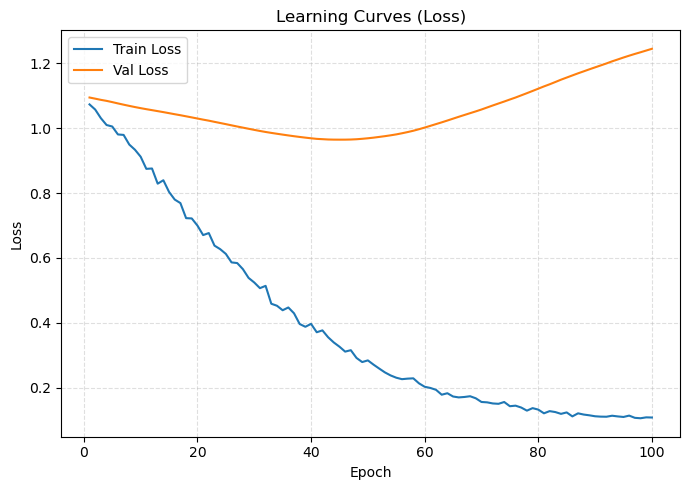

Saved learning curves PNG -> /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/learning_curves.png


In [19]:
# セル19 --- training loop (save to Runs/) ---
import copy
from math import inf

best_val_mae = inf
best_epoch = -1
epochs_without_improve = 0

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_mae": [], "val_rmse": [], "val_r2": []}

for epoch in range(1, num_epochs + 1):
    # ---- Train ----
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

    # ---- Eval (EMA優先) ----
    eval_model = model_ema.module if (model_ema is not None) else model
    val_loss, val_metrics, _ = evaluate(eval_model, val_loader, criterion, epoch, split="val")

    # ---- Scheduler + LR log ----
    if scheduler is not None:
        scheduler.step()

        lrs = [g["lr"] for g in optimizer.param_groups]
        print(
            f"Epoch {epoch} | "
            f"LR min={min(lrs):.8e} max={max(lrs):.8e} | "
            f"attn={lrs[-2]:.8e} head={lrs[-1]:.8e}"
        )
        print(
            f"Epoch {epoch} | "
            f"Current LR (group0 / backbone top)={optimizer.param_groups[0]['lr']:.10e}"
        )

    # ---- Log ----
    print(
        f"[Epoch {epoch:02d}] "
        f"train_loss={train_loss:.4f}  "
        f"val_loss={val_loss:.4f}  "
        f"MAE={val_metrics['MAE']:.3f}  "
        f"RMSE={val_metrics['RMSE']:.3f}  "
        f"R2={val_metrics['R2']:.4f}"
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(float(train_loss))
    history["val_loss"].append(float(val_loss))
    history["val_mae"].append(float(val_metrics["MAE"]))
    history["val_rmse"].append(float(val_metrics["RMSE"]))
    history["val_r2"].append(float(val_metrics["R2"]))

    # ---- Best update ----
    improved = val_metrics["MAE"] < best_val_mae - 1e-6
    if improved:
        best_val_mae = val_metrics["MAE"]
        best_epoch = epoch
        epochs_without_improve = 0

        # 推論用（EMA優先）
        torch.save(copy.deepcopy(eval_model.state_dict()), best_infer_path)

        cfg = {
            "base_lr": base_lr,
            "LR_REF": LR_REF,
            "effective_batch": effective_batch,
            "weight_decay": wd_backbone,   # backbone側
            "layer_decay": layer_decay,
            "num_epochs": num_epochs,
            "warmup_epochs": warmup_epochs,
        }

        snapshot = {
            "epoch": epoch,
            "model_state": copy.deepcopy(eval_model.state_dict()),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
            "scaler_state": scaler.state_dict() if scaler is not None else None,
            "best_val_mae": best_val_mae,
            "config": cfg,
        }
        torch.save(snapshot, best_train_path)

        print(f"  -> Best updated at epoch {epoch}: MAE={best_val_mae:.3f}")
        print(f"     Saved:\n       Inference: {best_infer_path}\n       Training : {best_train_path}")
    else:
        epochs_without_improve += 1
        print(f"  No improvement. Patience {epochs_without_improve}/{early_stop_patience}")

    # ---- Early stopping ----
    if epochs_without_improve >= early_stop_patience:
        print(
            f"\nEarly stopping at epoch {epoch}. "
            f"Best epoch={best_epoch} (Val MAE={best_val_mae:.3f})."
        )
        break


# ---- Learning curves ----
import matplotlib.pyplot as plt

epochs_run = history["epoch"]
plt.figure(figsize=(7, 5))
plt.plot(epochs_run, history["train_loss"], label="Train Loss")
plt.plot(epochs_run, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Loss)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(curve_png_path, dpi=150)
plt.show()

print(f"Saved learning curves PNG -> {curve_png_path}")

/tmp/ipykernel_3770983/3867304936.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_infer_path, map_location=device)


✅ Loaded best model: /home/user/デスクトップ/age_estimation_12.12/Runs/学習後モデル3/best_model_infer.pt


Infer train:   0%|          | 0/234 [00:00<?, ?it/s]/tmp/ipykernel_3770983/3867304936.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=amp_enabled):
                                                              


=== Train metrics ===
{'MAE': 1.763031244277954, 'RMSE': 2.4218541298243914, 'R2': 0.9456962987349087}



=== Val metrics ===
{'MAE': 6.759573936462402, 'RMSE': 8.599824291474697, 'R2': 0.31369224799176487}


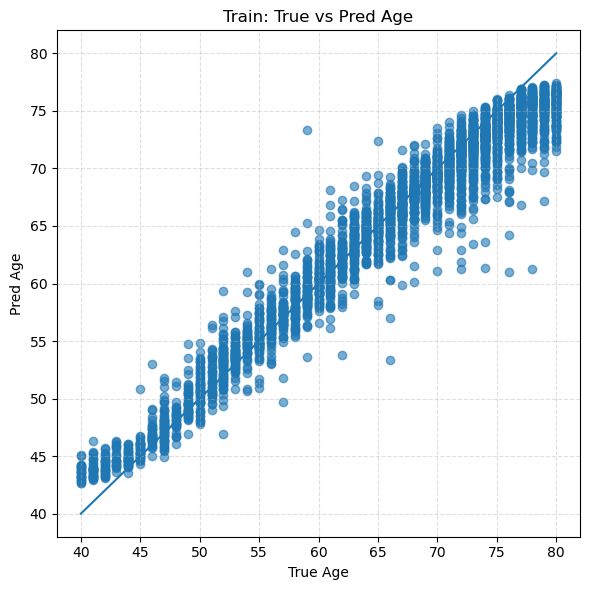

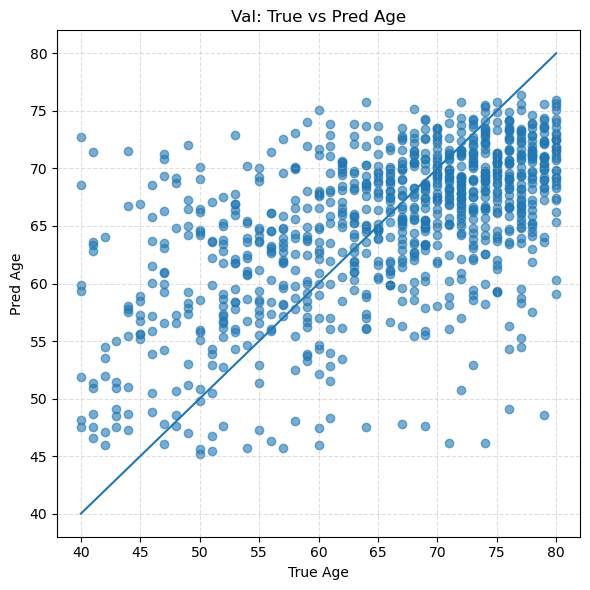

In [20]:
# セル20 --- 学習済みモデル読込 → train/val 推論 → 指標 + true-pred 2Dプロット ---
import numpy as np
import torch
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt

# --- 1) 推論用に「同じ設定」でモデルを作って重みをロード ---
# ※ best_infer_path はセル1で Runs 配下に設定済み
assert Path(best_infer_path).exists(), f"学習済みモデルが見つかりません: {best_infer_path}"

infer_model = AgeRegressorMIL_Attn(
    feat_dim=768,
    attn_hidden=256,
    dropout=0.1,
    head_hidden=512,
    n_bins=N_BINS,
).to(device)

state = torch.load(best_infer_path, map_location=device)
infer_model.load_state_dict(state, strict=True)
infer_model.eval()
print("✅ Loaded best model:", best_infer_path)

# --- 2) 推論関数（DataLoaderのNoneバッチに対応、患者単位で y_true/y_pred を集める） ---
@torch.no_grad()
def run_inference(model, loader, split_name: str = "val"):
    model.eval()
    y_true_all, y_pred_all = [], []

    for batch in tqdm(loader, desc=f"Infer {split_name}", leave=False):
        if batch is None:
            continue
        images_cat, patient_slices, ages, _pids = batch
        if len(patient_slices) == 0:
            continue

        ages = ages.to(device, non_blocking=True)
        total_patients = len(patient_slices)

        preds_collect = []

        for mb_start in range(0, total_patients, MICRO_PATIENTS):
            mb_end = min(mb_start + MICRO_PATIENTS, total_patients)

            mb_s = patient_slices[mb_start][0]
            mb_e = patient_slices[mb_end - 1][1]

            images_mb = images_cat[mb_s:mb_e].to(device, non_blocking=True)

            offset = mb_s
            slices_mb = [(s - offset, e - offset) for (s, e) in patient_slices[mb_start:mb_end]]

            with autocast(enabled=amp_enabled):
                preds_mb, _log_probs_mb = model(images_mb, slices_mb)

            preds_collect.append(preds_mb.detach().cpu().numpy())

            del images_mb, preds_mb, _log_probs_mb
            if device.type == "cuda":
                torch.cuda.empty_cache()

        y_true_all.append(ages.detach().cpu().numpy())
        y_pred_all.append(np.concatenate(preds_collect, axis=0))

    if len(y_true_all) == 0:
        return np.array([]), np.array([])

    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)
    return y_true_all, y_pred_all

# --- 3) train 推論 + 指標 ---
y_true_tr, y_pred_tr = run_inference(infer_model, train_loader, split_name="train")
if y_true_tr.size > 0:
    metrics_tr = compute_metrics(y_true_tr, y_pred_tr)
    print("\n=== Train metrics ===")
    print(metrics_tr)
else:
    print("\n⚠️ Train: 有効な推論結果がありません（全バッチNone等）")
    metrics_tr = None

# --- 4) val 推論 + 指標 ---
y_true_va, y_pred_va = run_inference(infer_model, val_loader, split_name="val")
if y_true_va.size > 0:
    metrics_va = compute_metrics(y_true_va, y_pred_va)
    print("\n=== Val metrics ===")
    print(metrics_va)
else:
    print("\n⚠️ Val: 有効な推論結果がありません（全バッチNone等）")
    metrics_va = None

# --- 5) 2次元プロット（true vs pred） ※各splitごとに1枚ずつ（サブプロット無し） ---
def plot_true_pred(y_true, y_pred, title: str):
    if y_true.size == 0:
        print(f"⚠️ {title}: plotを作れません（データなし）")
        return
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    # 参考線 y=x
    mn = float(min(y_true.min(), y_pred.min()))
    mx = float(max(y_true.max(), y_pred.max()))
    plt.plot([mn, mx], [mn, mx])  # 色指定しない
    plt.xlabel("True Age")
    plt.ylabel("Pred Age")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_true_pred(y_true_tr, y_pred_tr, "Train: True vs Pred Age")
plot_true_pred(y_true_va, y_pred_va, "Val: True vs Pred Age")